In [1]:
!python -m venv venv

Could not find platform independent libraries <prefix>


In [2]:
!pip install torch torchaudio librosa numpy scikit-learn

^C


Could not find platform independent libraries <prefix>


In [10]:
import os
import random

def find_wav_files(base_dir, is_train:bool, per_class=100):
    sub_root = '1.Training' if is_train else '2.Validation'

    wav_files = []
    emotion_dir = os.path.join(
        base_dir, 
        '01.데이터', 
        sub_root,
        '원천데이터',
        ('T' if is_train else 'V') + 'S1',
        ('T' if is_train else 'V') + 'S1',
        '1.감정'
    )
    
    for emo in os.listdir(emotion_dir):
        emo_path = os.path.join(emotion_dir, emo)
        if not os.path.isdir(emo_path): continue
        for sub_folder in os.listdir(emo_path):
            sub_emo_path = os.path.join(emo_path, sub_folder)
            if not os.path.isdir(sub_emo_path): continue

            wav_list = [
                os.path.join(sub_emo_path, f)
                for f in os.listdir(sub_emo_path) if f.endswith('.wav')
            ]
            if len(wav_list) == 0:
                continue
            
            # sampled = random.sample(wav_list, min(per_class, len(wav_list)))
            # wav_files.extend(sampled)
            wav_files.extend(wav_list)
    return wav_files


In [11]:
BASE_DIR = r'C:\Users\SSAFY\Downloads\015.감성 및 발화 스타일별 음성합성 데이터'
wav_list = find_wav_files(BASE_DIR, True, 10)

In [12]:
len(wav_list)

453924

In [13]:
def match_label_file(wav_path, base_dir:str, is_train:bool):
    wav_tag = 'TS' if is_train else 'VS' 
    json_tag = 'TL' if is_train else 'VL' 
    label_path = wav_path.replace("원천데이터", "라벨링데이터")
    label_path = label_path.replace(f'{wav_tag}1', f'{json_tag}1')
    label_path = label_path.replace(".wav", ".json")
    return label_path

label_path_list = [match_label_file(wav, BASE_DIR, True) for wav in wav_list if os.path.exists(wav)]
label_path_list[:5]

['C:\\Users\\SSAFY\\Downloads\\015.감성 및 발화 스타일별 음성합성 데이터\\01.데이터\\1.Training\\라벨링데이터\\TL1\\TL1\\1.감정\\1.기쁨\\0001_G1A3E1S0C0_PSB\\0001_G1A3E1S0C0_PSB_000001.json',
 'C:\\Users\\SSAFY\\Downloads\\015.감성 및 발화 스타일별 음성합성 데이터\\01.데이터\\1.Training\\라벨링데이터\\TL1\\TL1\\1.감정\\1.기쁨\\0001_G1A3E1S0C0_PSB\\0001_G1A3E1S0C0_PSB_000002.json',
 'C:\\Users\\SSAFY\\Downloads\\015.감성 및 발화 스타일별 음성합성 데이터\\01.데이터\\1.Training\\라벨링데이터\\TL1\\TL1\\1.감정\\1.기쁨\\0001_G1A3E1S0C0_PSB\\0001_G1A3E1S0C0_PSB_000003.json',
 'C:\\Users\\SSAFY\\Downloads\\015.감성 및 발화 스타일별 음성합성 데이터\\01.데이터\\1.Training\\라벨링데이터\\TL1\\TL1\\1.감정\\1.기쁨\\0001_G1A3E1S0C0_PSB\\0001_G1A3E1S0C0_PSB_000004.json',
 'C:\\Users\\SSAFY\\Downloads\\015.감성 및 발화 스타일별 음성합성 데이터\\01.데이터\\1.Training\\라벨링데이터\\TL1\\TL1\\1.감정\\1.기쁨\\0001_G1A3E1S0C0_PSB\\0001_G1A3E1S0C0_PSB_000005.json']

In [15]:
import json
from pprint import pprint
def get_emotion_label(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    # pprint(data['화자정보'])
    emotion = data['화자정보']['Emotion']
    return emotion

get_emotion_label(label_path_list[0])


'Happy'

In [ ]:
temp = dict()
for label in label_path_list:
    emo = get_emotion_label(label)
    if temp.get(emo, False): temp[emo] += 1
    else: temp[emo] = 1

In [7]:
temp

{'Happy': 330,
 'Sad': 320,
 'Angry': 320,
 'Anxious': 320,
 'Hurt': 320,
 'Embarrassed': 320,
 'Neutrality': 320}

In [8]:
_id = 0
label2id = dict()
id2label = dict()
for emo in temp.keys():
    label2id[emo] = _id
    id2label[_id] = emo
    _id += 1
    
del _id
print(label2id, id2label)

{'Happy': 0, 'Sad': 1, 'Angry': 2, 'Anxious': 3, 'Hurt': 4, 'Embarrassed': 5, 'Neutrality': 6} {0: 'Happy', 1: 'Sad', 2: 'Angry', 3: 'Anxious', 4: 'Hurt', 5: 'Embarrassed', 6: 'Neutrality'}


In [17]:
label2id = {'Happy': 0, 'Sad': 1, 'Angry': 2, 'Anxious': 3, 'Hurt': 4, 'Embarrassed': 5, 'Neutrality': 6}
id2label = {0: 'Happy', 1: 'Sad', 2: 'Angry', 3: 'Anxious', 4: 'Hurt', 5: 'Embarrassed', 6: 'Neutrality'}

In [ ]:
label_list = list(label2id[e] for e in map(get_emotion_label, label_path_list))

In [27]:
import librosa 

def load_audio(path, target_sr=16000):
    y, sr = librosa.load(path, sr=target_sr)
    return y

In [28]:
from sklearn.model_selection import train_test_split

train_files, test_files, train_labels, test_labels = train_test_split(
    wav_list, label_list, test_size=0.2, random_state=42)


In [21]:
from torch.utils.data import Dataset

class EmotionDataset(Dataset):
    def __init__(self, audio_paths, labels, target_sr=16000):
        self.audio_paths = audio_paths
        self.labels = labels
        self.target_sr = target_sr

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        wav = load_audio(self.audio_paths[idx], self.target_sr)
        label = self.labels[idx]
        return {"input_values": wav, "labels": label}


In [22]:
import numpy as np

def extract_mfcc(
    audio_path: str,
    sr: int = 16000,
    n_fft: int = 512,
    hop_length: int = 160,
    n_mfcc: int = 20
) -> np.ndarray:
    """
    오디오에서 MFCC + 델타·이중델타를 뽑아서 (frames, n_mfcc*3) 형태로 반환
    """
    # 1) 로드 & 프리엠퍼시스
    y, _ = librosa.load(audio_path, sr=sr)
    y = np.append(y[0], y[1:] - 0.97 * y[:-1])

    # 2) 멜 스펙트로그램 (파워 스펙트럼에 멜 필터뱅크 적용)
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))**2
    mel_basis = librosa.filters.mel(sr, n_fft, n_mels=26)
    mel_S = mel_basis @ S

    # 3) 로그 스케일  
    log_mel_S = np.log(mel_S + 1e-8)

    # 4) MFCC (DCT 적용)  
    mfcc = librosa.feature.mfcc(S=log_mel_S, n_mfcc=n_mfcc)

    # 5) 델타·이중델타 추가  
    mfcc_delta   = librosa.feature.delta(mfcc, order=1)
    mfcc_delta2  = librosa.feature.delta(mfcc, order=2)

    # 반환 형태: (frames, n_mfcc * 3)
    return np.concatenate([mfcc, mfcc_delta, mfcc_delta2], axis=0).T

In [23]:
from typing import List, Dict, Any

def create_feature_filter(
    per_emotion_importances: List[Dict[str, float]],
    top_k: int = 10
) -> Dict[str, float]:
    """
    per_emotion_importances:  
      [ {'MFCC_2':0.15, 'MFCC_8':0.12, …},    # 분노
        {'MFCC_1':0.11, 'Mel_4':0.09, …},    # 기쁨
        …                                 # 총 7개 감정
      ]
    반환: 공통 상위 top_k 특징의 평균 가중치 딕셔너리
    """
    # 1) 감정별로 상위 top_k 뽑기
    top_features = []
    for imp in per_emotion_importances:
        sorted_feats = sorted(imp.items(), key=lambda x: x[1], reverse=True)[:top_k]
        top_features.append({feat: weight for feat, weight in sorted_feats})

    # 2) 모든 감정에서 등장한 가중치 합산
    agg_weights: Dict[str, float] = {}
    for feats in top_features:
        for feat, w in feats.items():
            agg_weights[feat] = agg_weights.get(feat, 0.0) + w

    # 3) 합산 가중치 기준으로 다시 상위 top_k 선택
    common = dict(sorted(agg_weights.items(), key=lambda x: x[1], reverse=True)[:top_k])
    return common

def compute_emotion_index(
    features: Dict[str, Any],
    filter_weights: Dict[str, float]
) -> float:
    """
    features: {'MFCC_2': value, 'MFCC_8': value, …}
    filter_weights: {'MFCC_2': w2, 'MFCC_8': w8, …}
    수식 (3) 감정 지수:  Σ_i (feature_i * weight_i)
    """
    return sum(features.get(f, 0.0) * w for f, w in filter_weights.items())


In [25]:
from tqdm import tqdm

mfcc_root = "/data/mfcc_features"
os.makedirs(mfcc_root, exist_ok=True)

# 3) 전처리 루프
for wav_path in tqdm(wav_list, desc="Extracting MFCC"):
    try:
        mfcc = extract_mfcc(
            audio_path=wav_path,
            sr=16000,
            n_fft=512,
            hop_length=160,
            n_mfcc=20
        )  # returns shape (frames, n_mfcc*3)
        
        # 파일명 기준으로 저장
        fname = os.path.splitext(os.path.basename(wav_path))[0]
        out_path = os.path.join(mfcc_root, f"{fname}_mfcc.npy")
        np.save(out_path, mfcc)
        
    except Exception as e:
        # 오류가 난 파일은 로그로 남겨두기
        with open("mfcc_errors.log", "a") as log:
            log.write(f"{wav_path}\t{e}\n")

Extracting MFCC:   5%|▌         | 23354/453924 [04:35<1:24:30, 84.92it/s]


KeyboardInterrupt: 

In [17]:
torch.cuda.is_available()

True

In [28]:
import evaluate
import numpy as np
from IPython.display import Audio
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids

    accuracy = accuracy_score(y_true=labels, y_pred=predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [29]:
from torch.utils.data import DataLoader
import librosa
from transformers import Trainer, TrainingArguments

train_dataset = EmotionDataset(train_files, train_labels)
test_dataset = EmotionDataset(test_files, test_labels)
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=1,  # VRAM 적으면 1로
    per_device_eval_batch_size=1,
    num_train_epochs=5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    fp16=False,  # 3050은 mixed precision 지원
    learning_rate=1e-4,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor,
    data_collator=collate_fn,
    compute_metrics=compute_metrics
)
trainer.train()


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_33828\1326427802.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.958300,1.953369,0.104444,0.010909,0.104444,0.019754
2,1.919800,1.964084,0.104444,0.010909,0.104444,0.019754
3,1.943400,1.949484,0.104444,0.010909,0.104444,0.019754
4,1.933200,1.950270,0.104444,0.010909,0.104444,0.019754
5,1.955400,1.953544,0.104444,0.010909,0.104444,0.019754


c:\Users\SSAFY\Desktop\_fpjt\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SSAFY\Desktop\_fpjt\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SSAFY\Desktop\_fpjt\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\S

TrainOutput(global_step=9000, training_loss=1.9493119689093696, metrics={'train_runtime': 1804.2595, 'train_samples_per_second': 4.988, 'train_steps_per_second': 4.988, 'total_flos': 3.013354331487861e+17, 'train_loss': 1.9493119689093696, 'epoch': 5.0})

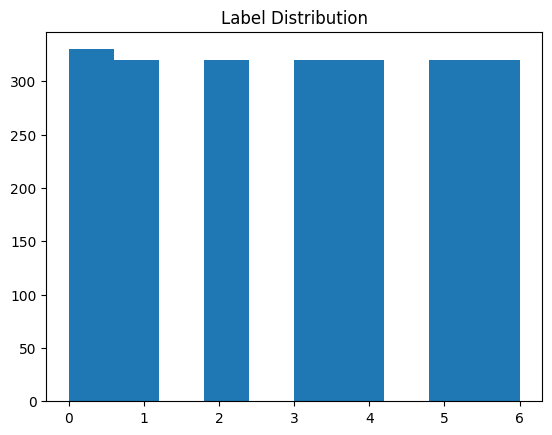

In [33]:
import matplotlib.pyplot as plt
plt.hist(label_list)
plt.title("Label Distribution")
plt.show()


In [34]:
print(len(train_dataset))
print(len(test_dataset))
print(len(label_list))
print(len(wav_list))


1800
450
2250
2250


In [37]:
# test_dataset은 이미 생성되어 있다고 가정
output = trainer.predict(test_dataset)
logits = output.predictions
labels = output.label_ids
print(output)
print(logits)
print(labels)


c:\Users\SSAFY\Desktop\_fpjt\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


PredictionOutput(predictions=array([[ 0.00122942, -0.05914168,  0.07904113, ..., -0.07488912,
         0.00148852, -0.03032699],
       [ 0.00122942, -0.0591417 ,  0.07904113, ..., -0.07488912,
         0.00148852, -0.03032699],
       [ 0.00122942, -0.05914169,  0.07904113, ..., -0.07488912,
         0.00148851, -0.03032699],
       ...,
       [ 0.00122942, -0.05914169,  0.07904113, ..., -0.07488911,
         0.00148852, -0.03032699],
       [ 0.00122942, -0.0591417 ,  0.07904113, ..., -0.07488912,
         0.00148852, -0.03032699],
       [ 0.00122942, -0.05914169,  0.07904114, ..., -0.07488912,
         0.00148852, -0.03032699]], shape=(450, 7), dtype=float32), label_ids=array([2, 1, 1, 0, 5, 5, 5, 1, 5, 4, 0, 4, 4, 6, 3, 4, 2, 6, 3, 4, 0, 1,
       3, 4, 6, 5, 2, 1, 6, 0, 4, 2, 2, 2, 3, 2, 6, 5, 2, 5, 0, 6, 3, 0,
       6, 6, 4, 4, 1, 5, 4, 0, 6, 6, 6, 4, 6, 2, 0, 6, 6, 0, 4, 1, 6, 5,
       5, 2, 1, 0, 4, 5, 5, 1, 3, 2, 4, 4, 0, 2, 1, 5, 5, 5, 4, 5, 0, 4,
       0, 3, 6, 5, 4, 5,

In [38]:
import numpy as np
from sklearn.metrics import classification_report

preds = np.argmax(logits, axis=1)
print(classification_report(labels, preds, digits=4))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        72
           1     0.0000    0.0000    0.0000        77
           2     0.1044    1.0000    0.1891        47
           3     0.0000    0.0000    0.0000        57
           4     0.0000    0.0000    0.0000        69
           5     0.0000    0.0000    0.0000        61
           6     0.0000    0.0000    0.0000        67

    accuracy                         0.1044       450
   macro avg     0.0149    0.1429    0.0270       450
weighted avg     0.0109    0.1044    0.0198       450



c:\Users\SSAFY\Desktop\_fpjt\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SSAFY\Desktop\_fpjt\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SSAFY\Desktop\_fpjt\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1]:
import numpy as np
from sklearn.metrics import classification_report

preds = np.argmax(logits, axis=1)
print(classification_report(labels, preds, digits=4))


NameError: name 'logits' is not defined

In [209]:
val_list = find_wav_files(BASE_DIR, False, 1)
ans = {
    '기쁨': 'Happy',
    '슬픔': 'Sad',
    '분노': 'Angry',
    '당황': 'Embarrassed',
    '상처': 'Hurt',
    '중립': 'Neutrality',
    '불안': 'Anxious'
}

res = 0

for wav in val_list:
    emo = wav.split("1.감정\\")[1].split("\\")[0][2:]
    inferred = infer(model, wav, device)
    if inferred == ans[emo]: res += 1
res = res / len(val_list) * 100
print(f'{res}%')

28.57142857142857%


In [141]:
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, accuracy_score

# ... (모델 학습 및 평가 루프는 동일)

# 1. 예측값과 실제값 수집
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# 2. 주요 지표 출력
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Macro F1:", f1_score(all_labels, all_preds, average='macro'))
print("Macro Recall:", recall_score(all_labels, all_preds, average='macro'))
print("Macro Precision:", precision_score(all_labels, all_preds, average='macro'))

# 3. 전체 리포트 (클래스별 지표 포함)
print(classification_report(all_labels, all_preds, digits=4))


Accuracy: 0.538
Macro F1: 0.531078086798181
Macro Recall: 0.5342598295980111
Macro Precision: 0.5319771190610262
              precision    recall  f1-score   support

           0     0.7423    0.7934    0.7670       639
           1     0.6358    0.6916    0.6625       694
           2     0.4507    0.5306    0.4874       637
           3     0.3595    0.3895    0.3739       611
           4     0.3737    0.2900    0.3265       607
           5     0.4860    0.4356    0.4594       675
           6     0.6760    0.6091    0.6408       637

    accuracy                         0.5380      4500
   macro avg     0.5320    0.5343    0.5311      4500
weighted avg     0.5350    0.5380    0.5345      4500



In [210]:
torch.save(model.state_dict(), "cnn_1d_model.pth")